In [ ]:
#上传并解压数据集
#!unzip dataset.zip

In [9]:
import pathlib
import random
import tensorflow as tf
import cv2
#加入高斯模糊
def random_noise(image,label):
    if (random.random()>0.2):
        return image,label
    image_blur = cv2.GaussianBlur(image,(15,15),0)
    return image_blur,label
#加入随机噪声
def random_noise(image,label):
    if (random.random()>0.2):
        return image,label
    noise_factor = 0.2*np.max(image)
    image_noisy = image + noise_factor * tf.random.normal(shape=image.shape)
    return image_noisy,label
def process_from_pathlabel(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image)
    image = tf.cast(image,dtype = tf.float32)
    image /= 255.0
    #image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label,24)
    return image,label
def load_data(data_dir):
    #此处找到数据集所在位置
    data_root = pathlib.Path(data_dir)
    #读取文件夹中所有图片的路径位置
    all_image_paths = list(data_root.glob("*/*"))
    all_image_paths = [str(path) for path in all_image_paths]
    #根据文件夹的名字确定label
    all_image_labels = [int(pathlib.Path(path).parent.name) for path in all_image_paths]
    train_image_paths = []
    train_image_labels = []
    valid_image_paths = []
    valid_image_labels = []
    #分割成train与valid两组数据集
    for c in range(len(all_image_labels)):
        if (random.random()<0.1):
            valid_image_paths.append(all_image_paths[c])
            valid_image_labels.append(all_image_labels[c])
        else:
            train_image_paths.append(all_image_paths[c])
            train_image_labels.append(all_image_labels[c])
    #直接将路径与标签作为元组输入
    train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths,train_image_labels))
    train_dataset = train_dataset.map(process_from_pathlabel)
    train_dataset = train_dataset.map(random_noise)
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_image_paths,valid_image_labels))
    valid_dataset = valid_dataset.map(process_from_pathlabel)
    return train_dataset,valid_dataset

In [10]:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Add,
    Activation,
    Dense,
    AveragePooling2D,
    Conv2D,
    Activation,
    Flatten,
    Dropout,
    Bidirectional,
    GRU,
    Reshape,
    BatchNormalization,
    TimeDistributed,
    Softmax,
    Permute,
    Dot
)
def ResidualBlock(x,ch,conv_size,stride):
    tmp = Conv2D(ch, conv_size, strides=stride, padding='same',activation="relu")(x)
    tmp = Conv2D(ch, conv_size, strides=stride, padding='same')(tmp)
    tmp = BatchNormalization(axis = 3)(tmp)
    x = AveragePooling2D((stride[0]**2,stride[1]**2), padding = 'same')(x)
    x = Conv2D(ch, (1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Add()([x,tmp])
    x = Activation("relu")(x)
    return x
def TF_Recognition_Model(isCompile = True):
    In = Input(shape=(513, 800, 3))
    x = ResidualBlock(In,16,(2,4),(2,2))
    x = ResidualBlock(x,24,(2,4),(2,2))
    x = ResidualBlock(x,48,(2,3),(1,3))
    freq, chan = x.get_shape()[2:4]
    x = TimeDistributed(Reshape([int(freq)*int(chan)]))(x)
    x = Bidirectional(GRU(32,return_sequences = True))(x)
    weight = TimeDistributed(Dense(1))(x)
    weight = Softmax(axis = 1)(weight)
    x = Dot(axes = 1)([weight,x])
    x = Flatten()(x)
    x = Dense(48, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(24, activation='softmax')(x)
    model = Model(inputs=In, outputs=x)
    if isCompile:
        opt = Adam(1e-5)
        model.compile(
            optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )
    return model

1.0 1.0
Train for 112 steps
112/112 [==============================] - 20s 178ms/step - loss: 0.0971 - accuracy: 0.9710
1.0 0.9956522
Train for 112 steps
112/112 [==============================] - 20s 175ms/step - loss: 0.0969 - accuracy: 0.9732
1.0 1.0
Train for 112 steps
112/112 [==============================] - 20s 176ms/step - loss: 0.0783 - accuracy: 0.9817
1.0 0.98695654
Train for 112 steps
112/112 [==============================] - 20s 176ms/step - loss: 0.0919 - accuracy: 0.9732


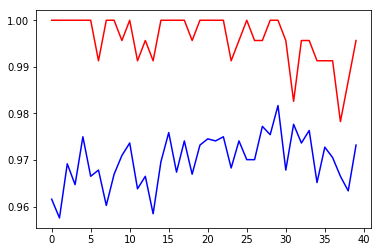

In [13]:
import numpy as np
#设定一些初始参数
num_classes = 24
image_shape = (513,800,3)
batch_size = 20
epoch = 40
lr = 0.0001
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#加载数据集
train_dataset,valid_dataset = load_data("dataset_clean/")
#进行训练集的处理
train_dataset = train_dataset.shuffle(100).repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
recog_model = tf.keras.models.load_model("model.h5")
#recog_model = TF_Recognition_Model()
max_acc = -1
train_acc = []
valid_acc = []
for i in range(epoch):
    if ((i+1) % 10 == 0):
        print(max_acc,history[-1])
        history = recog_model.fit(train_dataset,validation_split = 0,steps_per_epoch = 112, verbose = 1)
    else:
        history = recog_model.fit(train_dataset,validation_split = 0,steps_per_epoch = 112, verbose = 0)
    train_acc.append(history.history["accuracy"][-1])
    history = recog_model.evaluate(valid_dataset,verbose = 0)
    valid_acc.append(history[-1])
    if ((max_acc == -1) or (history[-1]>=max_acc)):
        recog_model.save("model.h5")
        max_acc = history[-1]
import matplotlib.pyplot as plt
plt.plot(train_acc, c = 'b')
plt.plot(valid_acc, c = "r")
plt.show()

In [12]:
%matplotlib inline
#加入噪声之前copy1-99.6%
recog_model = tf.keras.models.load_model("model.h5")
for i in range(10):
    train_dataset,valid_dataset = load_data("dataset/")
    valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    history = recog_model.evaluate(valid_dataset,verbose = 0)

FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition:   dataset/18/.ipynb_checkpoints; Is a directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) Failed precondition:   dataset/18/.ipynb_checkpoints; Is a directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_33338]

Function call stack:
distributed_function -> distributed_function -> distributed_function -> distributed_function


In [13]:
recog_model.save("model.h5")

In [1]:
!pip install opencv-python

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     |████████████████████████████████| 49.5 MB 732 kB/s eta 0:00:01
